In [1]:
import mindspore as ms
ms.set_context(mode=ms.GRAPH_MODE, device_target="GPU")

In [2]:
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore import nn, ops

data_root = r"./datasets"  
batch_size = 50
image_size = 70
nc=3
nz = 100          
ngf = 64                  
ndf = 64                 


def create_dataset_imagenet(data_path):    
    data = ds.ImageFolderDataset(data_path,num_parallel_workers=4, shuffle=True,decode=True)   
    transform = [
        vision.Resize(image_size),
        vision.RandomCrop([64, 64], [4, 4, 4, 4]), 
        vision.RandomHorizontalFlip(), 
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))]

    data = data.map(input_columns="image",num_parallel_workers=4,operations=transform,
                            output_columns=["image", "latent_code"],column_order=["image", "latent_code"])
    data = data.batch(batch_size)
    data=data.repeat(count=30)
    return data

data = create_dataset_imagenet(data_root)
size = data.get_dataset_size()
print(size)

570


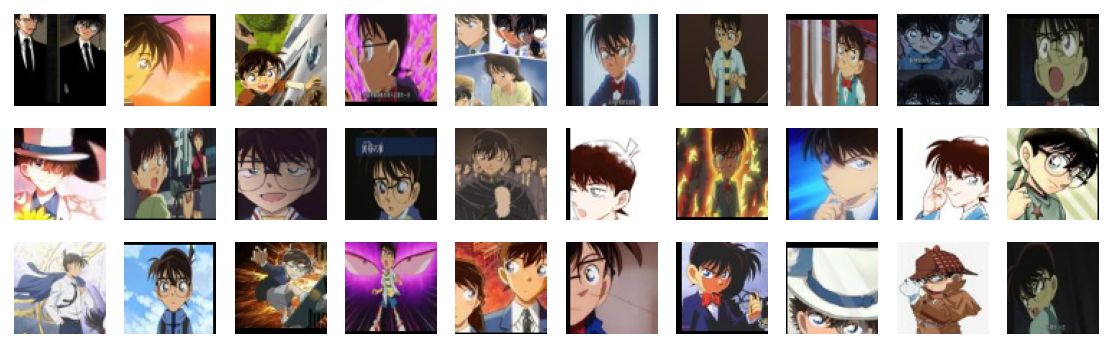

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

data_iter = next(data.create_dict_iterator(output_numpy=True))
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

In [4]:
from mindspore.common import initializer as init

def conv_transpose(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    weight_init = init.Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,kernel_size=kernel_size, stride=stride,
                               padding=padding,weight_init=weight_init, has_bias=False, pad_mode=pad_mode)
                              
def Batch_N2d(num_features):
    gamma_init = init.Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(conv_transpose(nz, ngf * 8, 4, 1, 0))
        self.generator.append(Batch_N2d(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_transpose(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(Batch_N2d(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_transpose(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(Batch_N2d(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_transpose(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(Batch_N2d(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_transpose(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)
    
netG = Generator()

In [5]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    weight_init = init.Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(Batch_N2d(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(Batch_N2d(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(Batch_N2d(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)
    
netD = Discriminator()

In [6]:
loss = nn.BCELoss(reduction='mean')

class GWithLoss(nn.Cell):
    def __init__(self, netD, netG, loss_fn):
        super(GWithLoss, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label_real = ops.OnesLike()(out)
        loss = self.loss_fn(out, label_real)
        return loss

In [7]:
class DWithLoss(nn.Cell):

    def __init__(self, netD, netG, loss_fn):
        super(DWithLoss, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        out_real = self.netD(real_data)
        label_real = ops.OnesLike()(out_real)
        loss_real = self.loss_fn(out_real, label_real)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out_fake = self.netD(fake_data)
        label_fake = ops.ZerosLike()(out_fake)
        loss_fake = self.loss_fn(out_fake, label_fake)
        
        return loss_real + loss_fake

In [8]:
lr=0.0001
beta1=0.5

optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

In [9]:
class DCGAN(nn.Cell):

    def __init__(self, TrainD, TrainG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.TrainD = TrainD
        self.TrainG = TrainG

    def construct(self, real_data, latent_code):
        output_D = self.TrainD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.TrainG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

In [10]:
netD_with_criterion = DWithLoss(netD, netG, loss)
netG_with_criterion = GWithLoss(netD, netG, loss)

TrainD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
TrainG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

In [11]:
dcgan = DCGAN(TrainD, TrainG)
dcgan.set_train()

np.random.seed(1)
fixed_noise = ms.Tensor(np.random.randn(64, nz, 1, 1), dtype=ms.float32)
num_epochs = 10           

data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

num_epochs = 10           
print("开始训练：")

for epoch in range(num_epochs):
    for i, d in enumerate(data_loader):
        real_data = ms.Tensor(d['image'])
        latent_code = ms.Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 100 == 0 or i == size - 1:
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    ms.save_checkpoint(netG, "Generator.ckpt")
    ms.save_checkpoint(netD, "Discriminator.ckpt")

开始训练
[ 1/10][  1/570]   Loss_D: 1.8617  Loss_G: 1.9618


KeyboardInterrupt: 

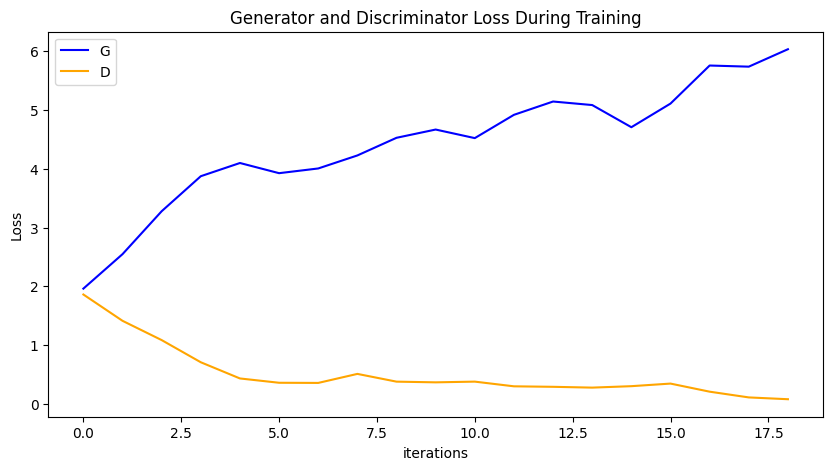

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random

number = random.randint(1,100)
np.random.seed(number)
fixed_noise = ms.Tensor(np.random.randn(64, nz, 1, 1), dtype=ms.float32)

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
    ani.save('./dcgan.gif', writer='pillow', fps=1)
showGif(image_list)

IndexError: list index out of range

<Figure size 960x360 with 0 Axes>